## Group: Yuna Ge, Anvita Panandikar, Charlotte Wang, Zixin Zhang

## Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')

from scipy import optimize
from scipy import interpolate

## Data

In [2]:
QUOTE_DATE = '2022-09-30'

filepath_rawdata = f'treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

In [3]:
data = rawdata[rawdata['ITYPE'] != 11]
finaldata = data[data['ITYPE'] != 12]
finaldata.head()

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,20221004.400000,2022-09-30,99.973333,99.973444,99.973389,M,I,0.000000,-1.389258e-07,0.000067,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207774,20221006.400000,2022-09-30,99.960917,99.961083,99.961000,M,I,0.000000,-2.542594e-05,0.000065,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207893,20221011.400000,2022-09-30,99.924986,99.925292,99.925139,M,I,0.000000,1.473347e-05,0.000068,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207868,20221013.400000,2022-09-30,99.907556,99.907917,99.907736,M,I,0.000000,-8.270836e-05,0.000071,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207430,20221015.201370,2022-09-30,99.921875,99.953125,99.937500,M,I,0.631148,3.735728e-05,0.000079,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN


## Functions

In [22]:
def get_maturity_delta(t_maturity,t_current):
    
    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')
    
    return pd.DataFrame(maturity_delta, columns=['Maturity'])

def calc_npv(rate=0, cashflows=0, maturities=0, price=0):
        
    temp = cashflows.copy()
    val = sum([cfi/(1+rate/2)**(maturities[i]*2) for i, cfi in enumerate(temp)])
    val += - price

    return val

def calc_cashflows(quote_data, filter_maturity_dates=False):
    
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['TMATDT'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100


    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)

    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    return CF

def get_coupon_dates(quote_date,maturity_date):
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out

def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):

    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # drop issues that had CF on excluded dates
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]

    else:
        # drop issues that have no CF on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
        
    # update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered

def filter_treasuries(data, t_date=None, filter_maturity = None, filter_maturity_min=None, drop_duplicate_maturities = False, filter_tips=True, filter_yld=True):
    outdata = data.copy()
    
    if t_date is None:
        t_date = outdata['CALDT'].values[-1]
    
    outdata = outdata[outdata['CALDT']==t_date]
    
    # Filter out redundant maturity
    if drop_duplicate_maturities:
        outdata = outdata.drop_duplicates(subset=['TMATDT'])
    
    # Filter by max maturity
    if filter_maturity is not None:
        mask_truncate = outdata['TMATDT'] < (t_date + np.timedelta64(365*filter_maturity+1,'D'))
        outdata = outdata[mask_truncate]

    # Filter by min maturity
    if filter_maturity_min is not None:
        mask_truncate = outdata['TMATDT'] > (t_date + np.timedelta64(365*filter_maturity_min-1,'D'))
        outdata = outdata[mask_truncate]

    outdata = outdata[outdata['ITYPE'].isin([11,12]) == (not filter_tips)]
        
    if filter_yld:
        outdata = outdata[outdata['TDYLD']>0]
        
    return outdata

def estimate_rate_curve(model,CF,t_current,prices,x0=None):

    if model is bootstrap:
        params = estimate_curve_ols(CF,prices,interpolate=False)
        
        CF_intervals = get_maturity_delta(CF.columns.to_series(),t_current=t_current).values
    
        params_optimized = [CF_intervals,params]

    else:
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones((1,4))/10
            elif model is nelson_siegel_extended:
                x0 = np.ones((1,6))
            else:
                x0 = 1        

        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x

    return params_optimized

def bootstrap(params,maturity):
    estimated_maturities = params[0].flatten()
    betas = params[1]
    estimated_rates = discount_to_intrate(betas,estimated_maturities)
    
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate

def estimate_curve_ols(CF,prices,interpolate=False):

    if isinstance(prices,pd.DataFrame) or isinstance(prices,pd.Series):
        prices = prices[CF.index].values
    
    mod = LinearRegression(fit_intercept=False).fit(CF.values,prices)

    if interpolate:
        matgrid = get_maturity_delta(CF.columns,CF.columns.min())

        dts_valid = np.logical_and(mod.coef_<1.25, mod.coef_>0)

        xold = matgrid[dts_valid]
        xnew = matgrid
        yold = mod.coef_[dts_valid]

        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')    
        discounts = f(xnew)

    else:
        discounts = mod.coef_    
        
    return discounts

def discount_to_intrate(discount, maturity, n_compound=None):
        
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)    
        
    return intrate

def compound_rate(intrate,compound_input,compound_output):
    
#    outrate = intrate[['maturity']]
    
    if compound_input is None:
        outrate = compound_output * (np.exp(intrate/compound_output) - 1)
    elif compound_output is None:
        outrate = compound_input * np.log(1 + intrate/compound_input)
    else:
        outrate = ((1 + intrate/compound_input) ** (compound_input/compound_output) - 1) * compound_output

    return outrate

def bootstrap_compound(params,maturity):
    estimated_maturities = params[0].flatten()
    betas = params[1]
    estimated_rates = discount_to_intrate(betas,estimated_maturities)
    compound = compound_rate(estimated_rates, None, 2)
    
    f = interpolate.interp1d(estimated_maturities, compound, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate

## Problem 1: Explore the Data
## 1 Maturity

In [5]:
get_maturity_delta(finaldata['TMATDT'], finaldata['CALDT'])

,Maturity
KYTREASNO,
207892,0.010951
207774,0.016427
207893,0.030116
207868,0.035592
207430,0.041068
...,...
207763,28.873374
207808,29.125257
207849,29.377139


## 2 Prices

In [6]:
dirty_price = (finaldata['TDBID'] + finaldata['TDASK'])/2 + finaldata['TDACCINT']
price_df = pd.DataFrame(dirty_price, columns=['Dirty Price'])
price_df

,Dirty Price
KYTREASNO,
207892,99.973389
207774,99.961000
207893,99.925139
207868,99.907736
207430,100.568648
...,...
207763,68.367188
207808,66.640625
207849,72.718750


## 3 YTM

In [7]:
CF = calc_cashflows(finaldata)

maturities = get_maturity_delta(finaldata['TMATDT'], finaldata['CALDT'])

ytm = pd.Series(index=finaldata.index, dtype='float64')

for i in finaldata.index:
    get_ytm = lambda y: price_df.loc[i]['Dirty Price'] - calc_npv(y, CF.loc[i,:].values, maturities.values)
    ytm.loc[i] = optimize.newton(get_ytm, 0.01)

display(pd.DataFrame(ytm, columns=['YTM']))

,YTM
KYTREASNO,
207892,0.024451
207774,0.023887
207893,0.025022
207868,0.026103
207430,0.028968
...,...
207763,0.113997
207808,0.091639
207849,0.088609


## 4 Summary Table

In [8]:
summary = pd.DataFrame(index=finaldata.index)

summary['Maturity'] = get_maturity_delta(finaldata['TMATDT'], finaldata['CALDT'])
summary['Price'] = finaldata['TDNOMPRC']
summary['Coupon Rate'] = finaldata['TCOUPRT']
summary['YTM'] = ytm
summary['TDYTM'] = finaldata['TDYLD'] * 365
summary['Bid-Ask'] = finaldata['TDBID'] - finaldata['TDASK']

summary

,Maturity,Price,Coupon Rate,YTM,TDYTM,Bid-Ask
KYTREASNO,,,,,,
207892,0.010951,99.973389,0.000,0.024451,0.024286,-0.000111
207774,0.016427,99.961000,0.000,0.023887,0.023730,-0.000167
207893,0.030116,99.925139,0.000,0.025022,0.024850,-0.000306
207868,0.035592,99.907736,0.000,0.026103,0.025917,-0.000361
207430,0.041068,99.937500,1.375,0.028968,0.028740,-0.031250
...,...,...,...,...,...,...
207763,28.873374,68.117188,2.000,0.113997,0.037968,-0.062500
207808,29.125257,65.937500,1.875,0.091639,0.037857,-0.046875
207849,29.377139,72.437500,2.250,0.088609,0.037800,-0.062500


In [9]:
summary.describe()

,Maturity,Price,Coupon Rate,YTM,TDYTM,Bid-Ask
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,6.204549,93.182685,1.886905,0.079318,0.039407,-0.039184
std,7.998196,9.041808,1.594043,0.028322,0.004203,0.021349
min,0.010951,55.835938,0.000000,0.023887,0.023730,-0.164444
25%,0.884326,88.515625,0.406250,0.070398,0.038246,-0.046875
50%,2.854209,95.675781,1.750000,0.080236,0.040750,-0.039062
75%,6.405886,98.730865,2.750000,0.082345,0.042347,-0.031250
max,29.875428,114.953125,7.625000,0.139754,0.043562,-0.000111


## 5 Plots

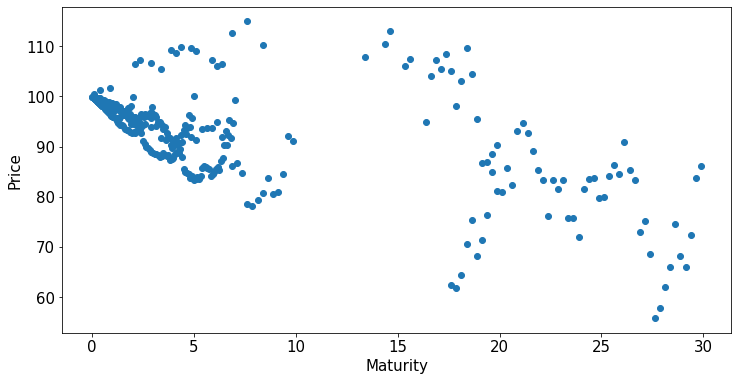

In [10]:
plt.scatter(get_maturity_delta(finaldata['TMATDT'], finaldata['CALDT']), finaldata['TDNOMPRC'])
plt.ylabel('Price')
plt.xlabel('Maturity')
plt.show()

## 6 Bad Data?

As seen below, 49 rows have TDYLD as NaN. The ITYPE of all of these issues is either 11 or 12, indicating that they are all TIPS (11= Inflation-Adjusted Bonds, 12 = Inflation-Adjusted Notes).

In [11]:
rawdata[rawdata['TDYLD'].isna()]

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
206582,20230115.C00120,2022-09-30,98.984375,98.992188,98.988281,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
207204,20230415.C00620,2022-09-30,98.613281,98.621094,98.617188,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
206642,20230715.C00370,2022-09-30,98.382812,98.394531,98.388672,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
206701,20240115.C00620,2022-09-30,97.609375,97.628906,97.619141,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
207348,20240415.C00500,2022-09-30,97.109375,97.132812,97.121094,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
206759,20240715.C00120,2022-09-30,96.503906,96.527344,96.515625,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
207431,20241015.C00120,2022-09-30,96.054688,96.085938,96.070312,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
206468,20250115.B02370,2022-09-30,100.253906,100.285156,100.269531,M,I,0.0,NaN,NaN,...,NaN,0,NaN,11,0,1,1,NaN,NaN,NaN
206816,20250115.C00250,2022-09-30,95.593750,95.625000,95.609375,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN


## Problem 2: Extract the Discount Curve
## 1 Map Cashflows

In [12]:
CF2 = calc_cashflows(finaldata[finaldata['TDYLD'] > 0])
display(CF2)

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207763,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.000,0.0000,1.000,0.0000,101.000,0.0000,0.000,0.0000,0.0
207808,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.9375,0.000,0.9375,0.000,0.9375,0.000,100.9375,0.000,0.0000,0.0
207849,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.125,0.0000,1.125,0.0000,1.125,0.0000,101.125,0.0000,0.0


In [13]:
print("Date which has the most cashflow across all issues:")
CF2.sum().idxmax()

Date which has the most cashflow across all issues:


Timestamp('2023-01-31 00:00:00')

In [14]:
print("Date which has the most issues paying a cashflows:")
CF2[CF2 > 0].count().idxmax()

Date which has the most issues paying a cashflows:


Timestamp('2023-02-15 00:00:00')

## 2 Bootstrap

In [15]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True

t_current = finaldata['CALDT'].values[0]

data = filter_treasuries(finaldata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF3 = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = price_df['Dirty Price'][CF3.index]
params_boot = estimate_rate_curve(MODEL,CF3,t_current,prices)

display(CF3)

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-31,...,2030-05-15,2030-08-15,2030-11-15,2031-02-15,2031-05-15,2031-08-15,2031-11-15,2032-02-15,2032-05-15,2032-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
207774,0,100,0,0,0.0000,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
207893,0,0,100,0,0.0000,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
207868,0,0,0,100,0.0000,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
207430,0,0,0,0,100.6875,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207761,0,0,0,0,0.0000,0,0,0,0,0,...,0.0000,0.6250,0.0000,0.6250,0.0000,100.6250,0.0000,0.0000,0.0000,0.000
207806,0,0,0,0,0.0000,0,0,0,0,0,...,0.6875,0.0000,0.6875,0.0000,0.6875,0.0000,100.6875,0.0000,0.0000,0.000
207847,0,0,0,0,0.0000,0,0,0,0,0,...,0.0000,0.9375,0.0000,0.9375,0.0000,0.9375,0.0000,100.9375,0.0000,0.000


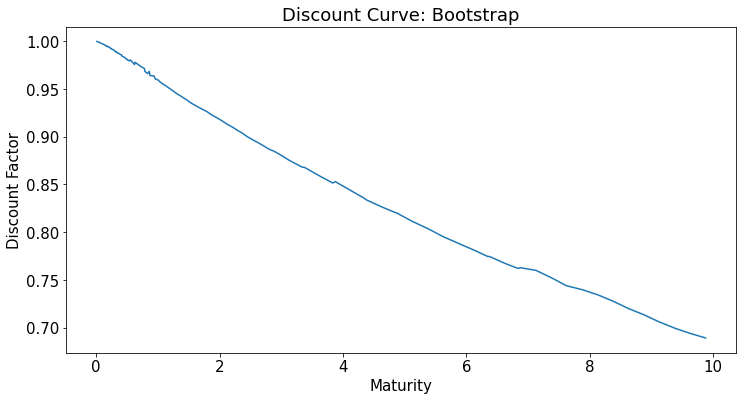

In [16]:
plt.plot(params_boot[0],params_boot[1])
plt.xlabel('Maturity')
plt.ylabel('Discount Factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

## 3. OLS

In [17]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False

data = filter_treasuries(finaldata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF4 = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = price_df['Dirty Price'][CF4.index]
params_OLS = estimate_rate_curve(MODEL,CF4,t_current,prices)

display(CF4)

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-31,...,2030-05-15,2030-08-15,2030-11-15,2031-02-15,2031-05-15,2031-08-15,2031-11-15,2032-02-15,2032-05-15,2032-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207761,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.6250,0.0000,0.6250,0.0000,100.6250,0.0000,0.0000,0.0000,0.000
207806,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.6875,0.0000,0.6875,0.0000,0.6875,0.0000,100.6875,0.0000,0.0000,0.000
207847,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.9375,0.0000,0.9375,0.0000,0.9375,0.0000,100.9375,0.0000,0.000


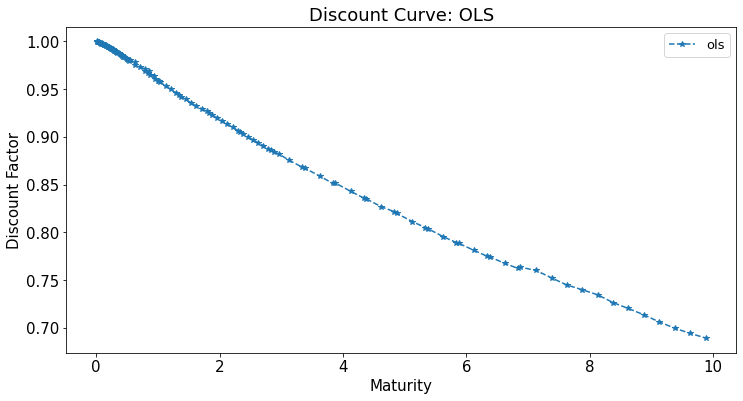

In [18]:
disc_ols = pd.DataFrame({'Maturity':params_OLS[0].flatten(), 'ols': params_OLS[1]}).set_index('Maturity')
disc_ols.plot(marker='*',linestyle='--',ylabel='Discount Factor',title='Discount Curve: OLS')
plt.show()

## 4 Factors and Rates

### Continuous discount rates:

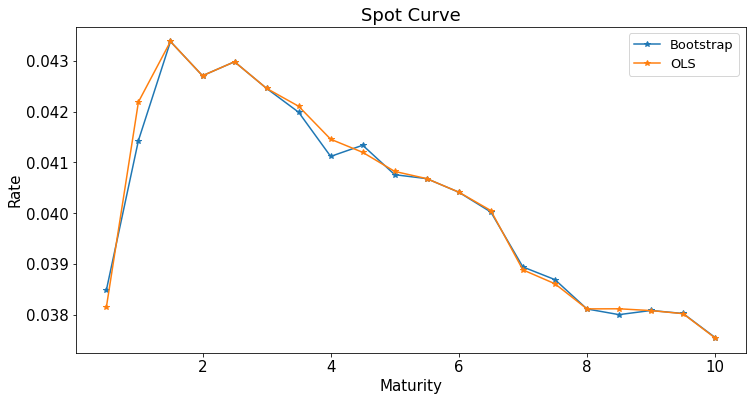

In [19]:
inc = .5

maturity_grid = np.arange(inc,disc_ols.index.to_series().max()+.5,inc)
curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['Bootstrap'] = bootstrap(params_boot,maturity_grid)
curves_ols['OLS'] = bootstrap(params_OLS,maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*',ylabel='Rate',xlabel='Maturity',title='Spot Curve')
plt.show()

### Semiannually compounded discount rates:

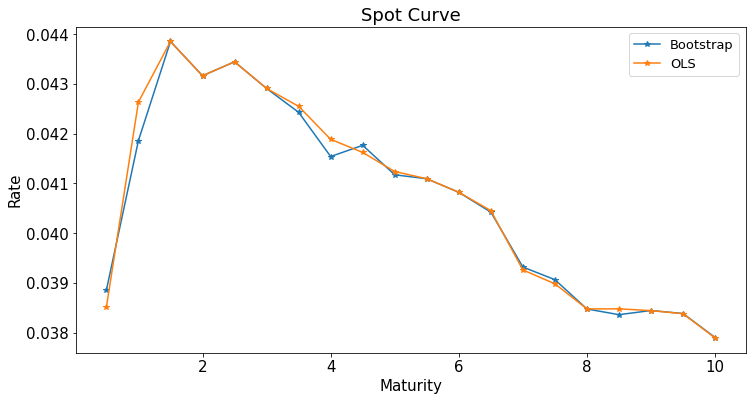

In [23]:
inc = .5

maturity_grid = np.arange(inc,disc_ols.index.to_series().max()+.5,inc)
curves_ols_2 = pd.DataFrame(index = maturity_grid)
curves_ols_2['Bootstrap'] = bootstrap_compound(params_boot,maturity_grid)
curves_ols_2['OLS'] = bootstrap_compound(params_OLS,maturity_grid)

ax = curves_ols_2.plot(linestyle='-',marker='*',ylabel='Rate',xlabel='Maturity',title='Spot Curve')
plt.show()